In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import cv2

### Read Image

(732, 732, 3)


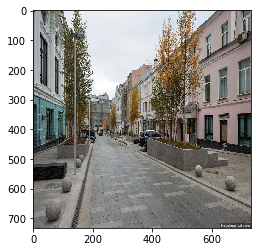

In [2]:
image = cv2.imread('Data/00s.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print(image.shape)

### Convert to grayscale

In [3]:
def rgb2gray(rgb):
    gray = np.mean(rgb, axis=2)
    return gray

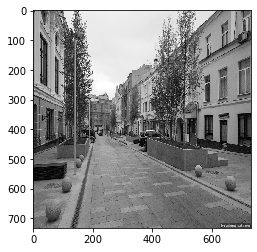

In [4]:
gray = rgb2gray(image)
plt.imshow(gray,cmap='gray')

### Binarization 

In [5]:
def Binarization(gray_img, threshold = 150):
    binarized = 1.0 * (gray_img > threshold)
    return binarized

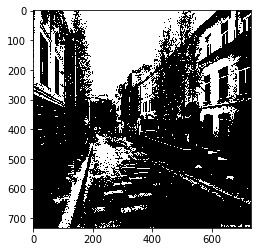

In [6]:
binary = Binarization(gray)
plt.imshow(binary, cmap='gray')

# Radon

In [7]:
from scipy.ndimage import rotate

In [8]:
def discrete_radon_transform(img, steps):
    # crate matrix
    w, h = img.shape
    zero = np.zeros((w, steps), dtype='float64')
    # sum and roatate
    for s in range(steps):
        rotation = rotate(img, s, reshape=False).astype('float64')
        # cut image
        cut = (rotation.shape[1] - rotation.shape[0]) / 2
        hm  = int(h - cut)
        hl  = int(cut)
        rotation = rotation[:,hl:hm]
        # sum
        zero[:, s] = np.sum(rotation, axis=0)
    # rotate image
    zero = rotate(zero, 180, reshape=False).astype('float64')
    return zero

In [9]:
radonn = discrete_radon_transform(gray, 180)

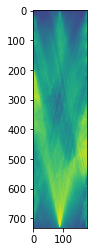

In [10]:
plt.imshow(radonn)

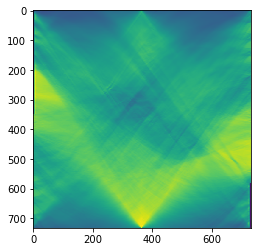

In [11]:
res = cv2.resize(radonn.T, dsize=(gray.shape), interpolation=cv2.INTER_CUBIC)
plt.imshow(res.T)

### Сравнение с библиоекой 

In [12]:
from skimage.transform import radon

c:\users\alkzir\appdata\local\programs\python\python37\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


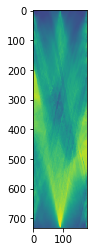

In [13]:
plt.imshow(radon(gray))

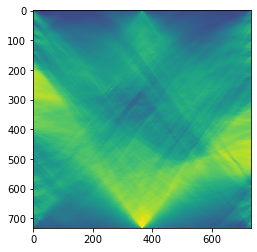

In [14]:
theta = np.linspace(0., 180., max(gray.shape), endpoint=False)
sinogram = radon(gray, theta=theta, circle=True)
plt.imshow(sinogram)

In [15]:
i,j = np.unravel_index(res.argmax(), res.shape)
print(i, j)

7 289


In [16]:
i,j = np.unravel_index(radonn.argmax(), radonn.shape)
print(i, j)

731 89


In [17]:
radonn.shape

(732, 180)

# Radon invert

1. Преобразование Фурье каждой проекции
2. Примените линейный фильтр путем умножения на |$\omega$|
3. Обратное преобразование Фурье для получения отфильтрованных проекций
4. Обратный проект отфильтрованных прогнозов и подвести итог

In [18]:
from scipy.fftpack import fft, ifft, fftfreq
from scipy.interpolate import interp1d

In [19]:
theta   = np.linspace(0., 180., max(gray.shape), endpoint=False)
singram = radon(gray, theta=theta, circle=True)

In [50]:
def sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    #np.pad pads an array, 
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)

In [58]:
def iradon_transform(sinogram, theta=None, interpolation='linear'): #filtered back projection will kill me
    output_size = sinogram.shape[0]
    sinogram = sinogram_circle_to_square(sinogram) #stretching
    th = (np.pi / 180.0)*theta
    
    projection_size = max(64, int(2**np.ceil(np.log2(2*sinogram.shape[0])))) 
    size_width = ((0, projection_size - sinogram.shape[0]),(0,0))
    image = np.pad(sinogram, size_width, mode='constant', constant_values=0)

    
    return image

In [59]:
iradon_transform(singram, theta=theta).shape

(4096, 732)